In [1]:
import simulation_settings as ss
import ship as ship
import constants
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [4]:
ww = ss.JONSWAP(10,4,2)
pp = ship.Particle(0,0.185)
dt = constants.dt
t=0
dl = []
xl = []
xvl = []
xal = []
zl = []
zvl= []
zal =[]
eng = []
pl = []
# pp.hoge("foo")
for i in range(1000):
    pp.update(ww,t,20)
    
    dl.append(pp.draught)
    xl.append(pp.posx)
    xvl.append(pp.velx)
    xal.append(pp.accx)
    zl.append(pp.posz)
    zvl.append(pp.velz)
    zal.append(pp.accz)
    pl.append(pp.angle)
    eng.append(pp.mass*pp.velz**2)
    t+=dt

(array([2., 0., 2., 0., 1., 1., 1., 1., 1., 1.]),
 array([0.47813625, 1.04285294, 1.60756962, 2.17228631, 2.737003  ,
        3.30171968, 3.86643637, 4.43115306, 4.99586974, 5.56058643,
        6.12530312]),
 <a list of 10 Patch objects>)

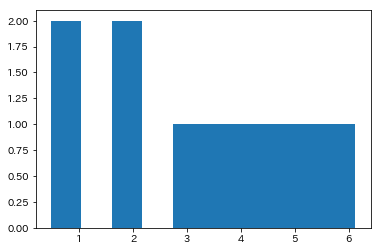

In [5]:
fig, ax = plt.subplots()

ol = []

for w in ww.waves:
    ol.append(w.omega)

ax.hist(ol)

In [6]:
fig, ax = plt.subplots()
tdata = np.arange(0,10000*dt,dt)
# ax.set_ylim(-0.5,0.5)
ax.
ax.plot(tdata,zl,label="pos")
# ax.plot(tdata,zvl,label="vel")
# ax.plot(tdata,zal,label="acc")
# ax.plot(tdata,dl,label="draught")
# ax.plot(tdata,eng,label="energy")
# ax.plot(tdata,pl,label="pitch angle")
ax.plot(xl,zl)
ax.legend()

SyntaxError: invalid syntax (<ipython-input-6-85844ba04b56>, line 4)

Text(0.5,1,'draught')

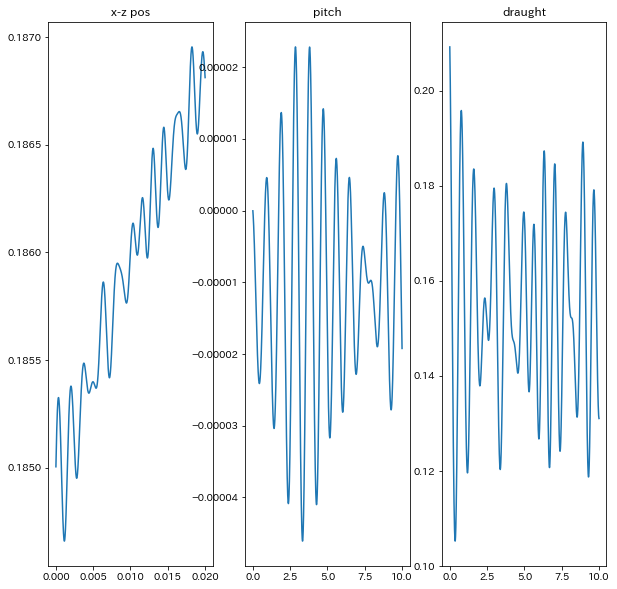

In [82]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3,figsize=(10,10))

ax1.plot(xl,zl)
ax1.set_title('x-z pos')

ax2.plot(tdata,pl)
ax2.set_title('pitch')

ax3.plot(tdata,dl)
ax3.set_title('draught')

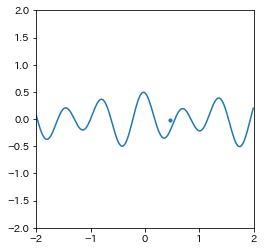

In [12]:


xdata = np.arange(-2,2,0.01)
ydata = np.array([ww.get(x,t) for x in xdata])
fig, ax = plt.subplots()
ax.set_xlim(-2.0,2.0)
ax.set_ylim(-2.0,2.0)
ax.set_aspect('equal', adjustable='box')

ax.plot(xdata,ydata)
ax.scatter(pp.posx,pp.posz,s=10)
t+=dt
pp.update(en_thr=False)